Plot the 3D trajectory of different demonstration of different tasks with gripper state.

Save the data as [position, yaw, gripper_state] in a csv file.

In [1]:
# load the data from jason file 
import numpy as np
import json
import math

In [2]:
def quaternion_to_yaw(w, x, y, z):
    # Calculate the yaw (Z-axis rotation)
    yaw = math.atan2(2.0 * (w * z + x * y), 1.0 - 2.0 * (y * y + z * z))
    # Convert the yaw from radians to degrees
    yaw_degrees = math.degrees(yaw)
    return yaw_degrees

In [3]:
# load the data from json file
file_name = "pick_place.json"
with open(file_name) as file:
        datas = json.load(file)
# create 2d array for position, orientation and gripper state
position = []
orientation = []
gripper_state = []
for data in datas:
    position.append(data['pose'])
    orientation.append(quaternion_to_yaw(*data['orn']))
    gripper_state.append(data['gripper_state'])

# convert the list to numpy array
position = np.array(position[5:])
orientation = np.array(orientation[5:])
gripper_state = np.array(gripper_state[5:])

1. functions to remove close points, and smooth the trajectory
2. plot the two finger gripper shape 

In [4]:
# a simple function to remove the position that are too close
def remove_close_position(position, threshold = 0.02):
    new_position = []
    save_index = []
    new_position.append(position[0])
    save_index.append(0)
    for i in range(1, len(position)):
        if np.linalg.norm(np.array(position[i]) - np.array(new_position[-1])) > threshold:
            new_position.append(position[i])
            save_index.append(i)
    return np.array(new_position), save_index

# smooth the position data and keep the final value the same
def smooth_position(position, window_size = 5):
    new_position = []
    for i in range(len(position) - window_size):
        new_position.append(np.mean(position[i:i+window_size], axis = 0))
    new_position.append(position[-1])
    return np.array(new_position)

In [5]:
# function to print the gripper shapes in the plot 
def get_gripper_coords(end_pose, angle, scale=0.01, gripper_state=1):
    # Length of the fingers and base width
    finger_length = 8 * scale
    base_width = 2 * scale * gripper_state
    handle_length = 9 * scale
    
    # Coordinates of the base (rotating)
    base = np.array([
        [-base_width / 2, 0, 0],
        [base_width / 2, 0, 0]
    ]) - np.array([0,0,handle_length])
    
    # Coordinates of the handle (fixed)
    handle = np.array([
        [0, 0, 0],       
        [0, 0, -handle_length]
    ])
    
    # Coordinates of the fingers (rotating)
    left_finger = np.array([
        [-base_width / 2, 0, 0],
        [-base_width / 2, 0, -finger_length]
    ]) - np.array([0,0,handle_length])
    
    right_finger = np.array([
        [base_width / 2, 0, 0],
        [base_width / 2, 0, -finger_length]
    ]) - np.array([0,0,handle_length])
    
    # Rotation matrix around Z-axis
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])
    
    # Rotate the fingers, and base    
    base = np.dot(base, rotation_matrix) + end_pose
    left_finger = np.dot(left_finger, rotation_matrix) + end_pose
    right_finger = np.dot(right_finger, rotation_matrix) + end_pose
    handle += end_pose
    
    return base, handle, left_finger, right_finger

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# remove the close position
position, save_index = remove_close_position(position)
# update the orientation and gripper state
orientation = orientation[save_index]
gripper_state = gripper_state[save_index]

# gripper_state[:] = 1

# # remove all the data after 22
# position = position[:22]
# orientation = orientation[:22]
# gripper_state = gripper_state[:22]


# # # repeat final state 5 times
# # final_position = np.repeat(position[-1, :][np.newaxis, :], 5, axis = 0)
# # final_orientation = np.repeat(orientation[-1], 5)
# # final_gripper_state = np.repeat(gripper_state[-1], 5)

# # print the shape of final_position
# print("final_position shape:", final_position.shape)

# position = np.concatenate([position, final_position])
# orientation = np.concatenate([orientation, final_orientation])
# gripper_state = np.concatenate([gripper_state, final_gripper_state])

# gripper_state[-5:] = np.array([0.9, 0.8, 0.7, 0.6, 0.52888889])

# print("gripper state:", gripper_state[18:])


lenght of trajectory: 35


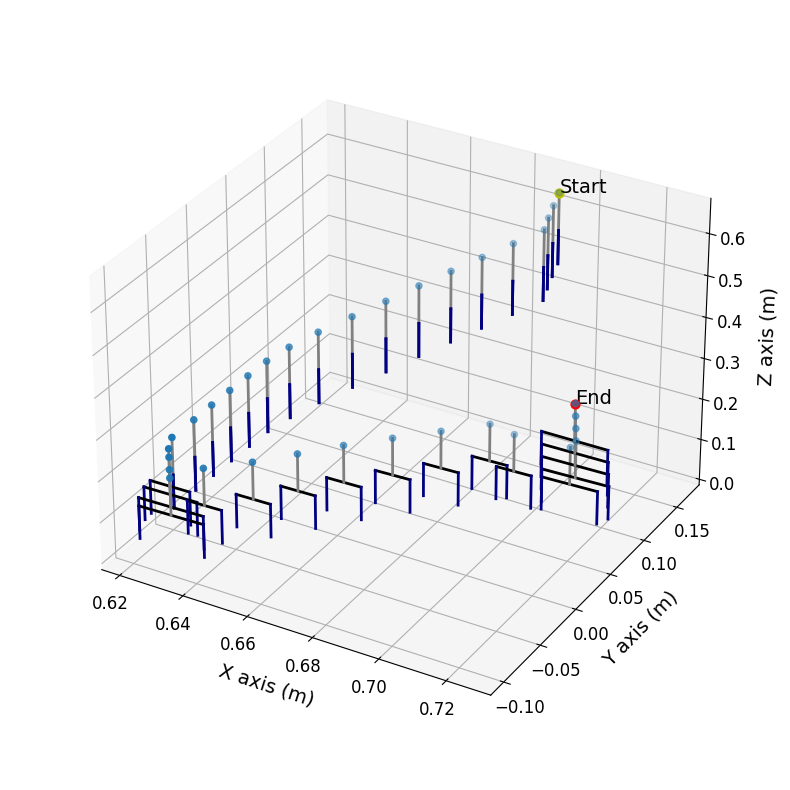

In [7]:
# plot position in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#fig.patch.set_facecolor('lightgray')  # Set figure background color
#ax.set_facecolor('whitesmoke')  # Set axes background color
# print the length of the position
print("lenght of trajectory:",len(position))
ax.scatter(position[:,0], position[:,1], position[:,2])
# draw start and end point
ax.scatter(position[0][0], position[0][1], position[0][2], c='y', marker='o', s=40)
ax.scatter(position[-1][0], position[-1][1], position[-1][2], c='r', marker='o',s=40)

# # plot the gripper for each position
for i in range(len(position)):
    base, handle, left_finger, right_finger = get_gripper_coords(position[i], orientation[i], 0.01, gripper_state[i])
    ax.plot(base[:,0], base[:,1], base[:,2], 'k-', lw=2)
    ax.plot(handle[:,0], handle[:,1], handle[:,2], color='gray', lw=2)
    ax.plot(left_finger[:,0], left_finger[:,1], left_finger[:,2], color='navy', lw=2)
    ax.plot(right_finger[:,0], right_finger[:,1], right_finger[:,2],color='navy', lw=2)

# Customize labels with font size
ax.set_xlabel('X axis (m)', fontsize=14, labelpad=10)
ax.set_ylabel('Y axis (m)', fontsize=14, labelpad=10)
ax.set_zlabel('Z axis (m)', fontsize=14, labelpad=10)

# Optionally, set tick parameters to adjust tick labels' font size
ax.tick_params(axis='x', labelsize=12)  # Set font size for x-axis ticks
ax.tick_params(axis='y', labelsize=12)  # Set font size for y-axis ticks
ax.tick_params(axis='z', labelsize=12)  # Set font size for z-axis ticks

ax.set_box_aspect(aspect=None, zoom=0.9)

ax.text(*position[0][:3], 'Start', color='black', fontsize=14)
ax.text(*position[-1][:3], 'End', color='black', fontsize=14)
plt.show()

In [8]:
print(position.shape)
print(orientation.shape)
print(gripper_state.shape)

(35, 3)
(35,)
(35,)


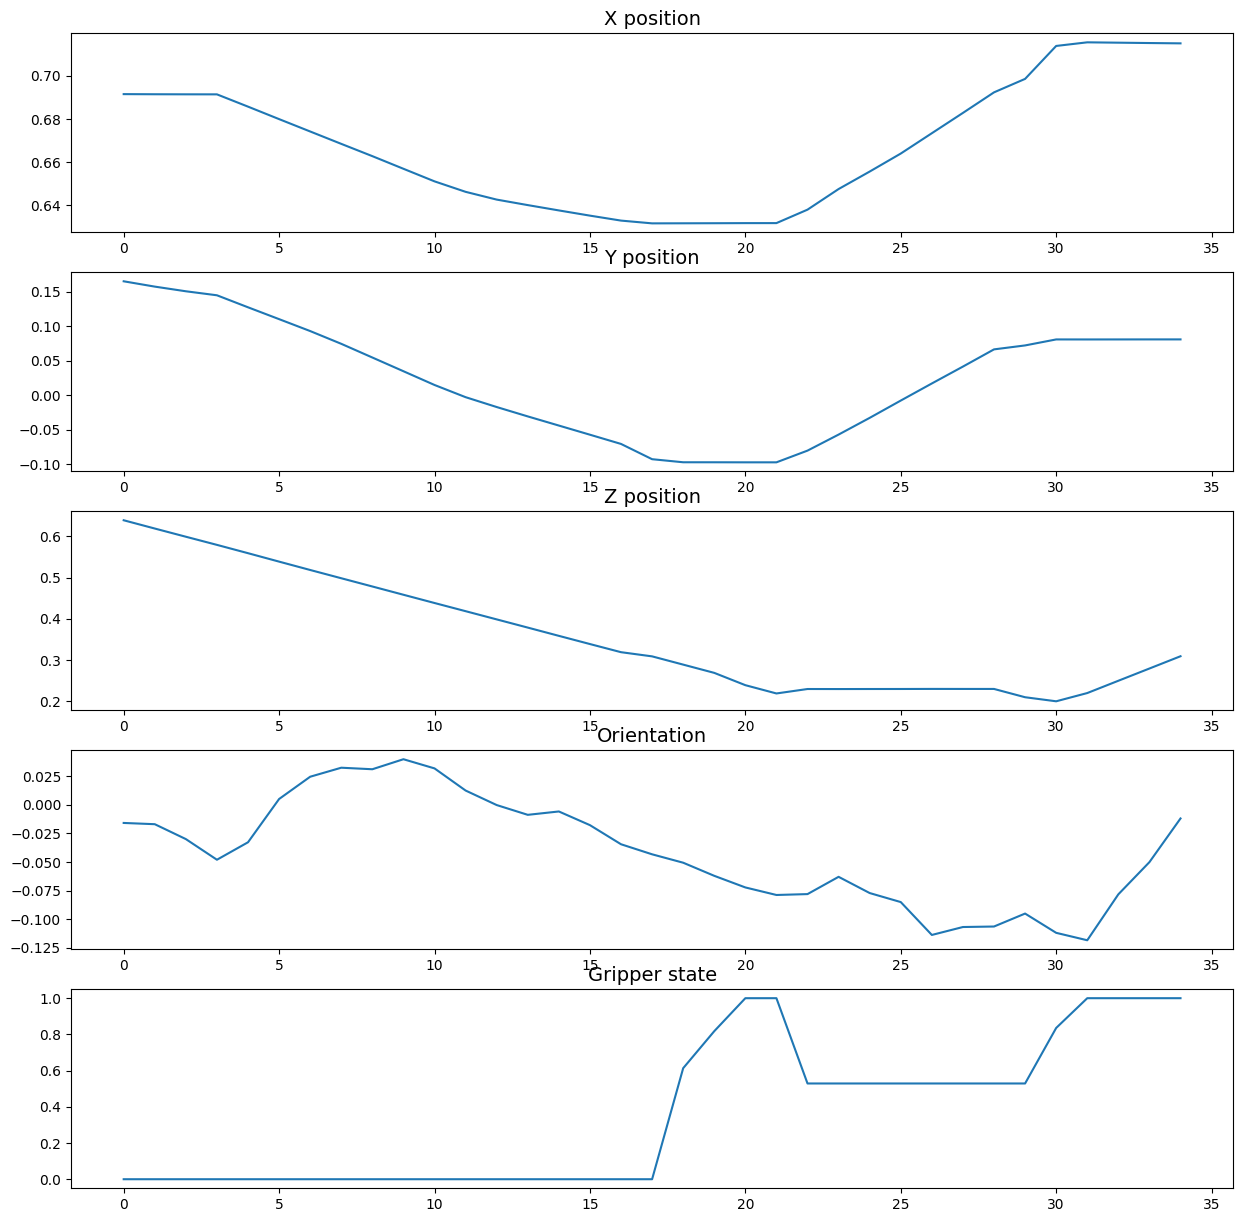

In [9]:
# plot trajectory in 2D for each dimension
fig, axs = plt.subplots(5, 1)
# setup the size of the figure
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0].plot(position[:,0])
axs[0].set_title('X position', fontsize=14)
axs[1].plot(position[:,1])
axs[1].set_title('Y position', fontsize=14)
axs[2].plot(position[:,2])
axs[2].set_title('Z position', fontsize=14)
axs[3].plot(orientation)
axs[3].set_title('Orientation', fontsize=14)
axs[4].plot(gripper_state)
axs[4].set_title('Gripper state', fontsize=14)
plt.show()

In [10]:
# combine the data to a single array
data = np.concatenate((position, orientation[:, np.newaxis], gripper_state[:, np.newaxis]), axis = 1)
print(data.shape)

# save the data to a new file
# get the file name without extension
file_name = file_name.split('.')[0]
np.save("3_"+file_name + "_data.npy", data)

(35, 5)
